In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Platform (Unified) SDK: Custom image classification model using a training pipeline with a managed dataset input

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/deepdive/custom/ucaip_customjob_image_pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/deepdive/custom/ucaip_customjob_image_pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Overview


This tutorial demonstrates how to use the AI Platform (Unified) Python SDK to train a custom image classification model with a [training pipeline](https://cloud.google.com/ai-platform-unified/docs/training/create-training-pipeline).

### Dataset

The dataset used for this tutorial is the [Flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset you will use in this tutorial is stored in a public Cloud Storage bucket. The trained model predicts the type of flower an image is from a class of five flowers: daisy, dandelion, rose, sunflower, tulip.

### Objective

In this notebook, you will learn how to create a custom image classification model, using a training pipeline that that uses a managed dataset as the input and a custom container for the training step.

The steps performed include: 

- Creating a AI Platform (Unified) datasets.
- Creating a AI Platform (Unified) custom job that uses a custom training container.
- Creating a training pipeline.
- Starting the training pipeline job.
- Monitoring the training pipeline job.
- Retrieve and load the trained model artifacts.
- View the model evaluation.
- Deploy the model to a serving endpoint.
- Make a prediction(s).
- Undeploy the model.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* Cloud AI Platform
* Cloud Storage

Learn about [Cloud AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the latest (preview) version of AI Platform (Unified) SDK.

In [ ]:
%pip install -U google-cloud-aiplatform

Install cloudstorage as well.

In [ ]:
%pip install -U google-cloud-storage

Install openCV, which will be used for creating test images.

In [ ]:
%pip install -U opencv-python

### Restart the Kernel

Once you've installed the AI Platform (Unified) SDK, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### GPU run-time

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select Runtime --> Change runtime type**

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs, Compute Engine APIs and Container Registry API.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,containerregistry.googleapis.com)

4. [Google Cloud SDK](https://cloud.google.com/sdk) is already installed in AI Platform Notebooks.

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Project ID

**If you don't know your project ID**, you might be able to get your project ID using `gcloud` command by executing the second cell below.

In [204]:
PROJECT_ID = "jk-mlops-dev" #@param {type:"string"}

In [205]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [206]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You can
not use a Multi-Regional Storage bucket for training with AI Platform.

In [207]:
REGION = 'us-central1' #@param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [208]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

In [209]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
# to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists('/opt/deeplearning/metadata/env_version'):
    if 'google.colab' in sys.modules:
        from google.colab import auth as google_auth
        google_auth.authenticate_user()

    # If you are running this tutorial in a notebook locally, replace the string
    # below with the path to your service account key and run this cell to
    # authenticate your Google Cloud account.
    else:
        %env GOOGLE_APPLICATION_CREDENTIALS your_path_to_credentials.json

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a custom training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform endpoint based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [210]:
BUCKET_NAME = "jk-ucaip-demos" #@param {type:"string"}

In [211]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "ucaip-custom-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [212]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://jk-ucaip-demos/...
ServiceException: 409 Bucket jk-ucaip-demos already exists.


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [213]:
! gsutil ls -al gs://$BUCKET_NAME

      1895  2020-12-04T16:09:14Z  gs://jk-ucaip-demos/trainer_cifar.tar.gz#1607098154322441  metageneration=1
                                 gs://jk-ucaip-demos/custom_job_20201204142829/
TOTAL: 1 objects, 1895 bytes (1.85 KiB)


### Import libraries and define constants

In [236]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import AI Platform (Unified) SDK

Import the AI Platform (Unified) SDK into our python environment.

In [214]:
import json
import os
import sys
import time

import tensorflow as tf
import tensorflow_io as tfio

from google.protobuf import json_format

from google.cloud.aiplatform import gapic as aip

#### AI Platform (Unified) constants

Let's now setup some constants for AI Platform (Unified):

- `API_ENDPOINT`: The AI Platform (Unified) API service endpoint for dataset, model, job, pipeline and endpoint services.
- `API_PREDICT_ENDPOINT`: The AI Platform (Unified) API service endpoint for prediction.
- `PARENT`: The AI Platform (Unified) location root path for dataset, model and endpoint resources.

In [215]:
# API Endpoint
API_ENDPOINT = "us-central1-aiplatform.googleapis.com"
API_PREDICT_ENDPOINT = "us-central1-prediction-aiplatform.googleapis.com"

# AI Platform (Unified) location root path for your dataset, model and endpoint resources
PARENT = "projects/" + PROJECT_ID + "/locations/" + REGION

# Default timeout for API calls
TIMEOUT = 60

#### AI Platform (Unified) Dataset constants

In [216]:
# Image dataset type
IMAGE_SCHEMA = 'google-cloud-aiplatform/schema/dataset/metadata/image_1.0.0.yaml'

#Image labeling type
IMPORT_SCHEMA_IMAGE_CLASSIFICATION = 'gs://google-cloud-aiplatform/schema/dataset/ioformat/image_classification_single_label_io_format_1.0.0.yaml'

#### Custom Job constants

#### Hardware Accelerators

Let's now set the hardware accelerators (e.g., GPU), if any, for training and prediction.

Set the variable `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the compute instance. For example, to use a GPU container image with 4 Nvidia Telsa K80 GPUs allocated to each compute instance, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

For GPU, available accelerators include:
   - aip.AcceleratorType.NVIDIA_TESLA_K80
   - aip.AcceleratorType.NVIDIA_TESLA_P100
   - aip.AcceleratorType.NVIDIA_TESLA_P4
   - aip.AcceleratorType.NVIDIA_TESLA_T4
   - aip.AcceleratorType.NVIDIA_TESLA_V100

   
Otherwise specify (`None, None`) for the container image for a CPU.
   
*Note*, TF releases before 2.3 for GPU support will fail to load the custom model in this tutorial. It is a known issue and fixed in TF 2.3 -- which is caused by static graph ops that are generated in the serving function. If you encounter this issue on your own custom models, the workaround is to create your own docker container image for TF 2.3 with GPU support.

In [217]:
TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Base container (Docker) image

Next, we will set the base docker container image for a custom training container.

- Set the variable `BASE_TRAIN_IMAGE` to the Tensorflow version of the container image. 
   
Google Cloud AI continously adds new training and prediction container images. For the lastest list, see [Pre-built containers for training](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/ai-platform-unified/docs/predictions/pre-built-containers)

In [218]:
CUSTOM_TASK_GCS_PATH = "gs://google-cloud-aiplatform/schema/trainingjob/definition/custom_task_1.0.0.yaml"

TRAIN_VERSION = '2-3'

BASE_TRAIN_IMAGE  = "gcr.io/deeplearning-platform-release/tf2-gpu.{}".format(TRAIN_VERSION)
#DEPLOY_IMAGE = "gcr.io/cloud-aiplatform/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", BASE_TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
#print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Training: gcr.io/deeplearning-platform-release/tf2-gpu.2-3 AcceleratorType.NVIDIA_TESLA_K80 1


#### Machine Type

Next, you will set the machine type (compute instance) you will use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to the compute instance you will use for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU.
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memoryn per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]
 
*Note, the following is not supported for training*
 
 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs
 
*Note, you may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*

In [219]:
MACHINE_TYPE = 'n1-standard'
VCPU='4'
TRAIN_COMPUTE = MACHINE_TYPE + '-' + VCPU
print('Train Compute Instance', TRAIN_COMPUTE)

MACHINE_TYPE = 'n1-standard'
VCPU='4'
DEPLOY_COMPUTE = MACHINE_TYPE + '-' + VCPU
print('Deploy Compute Instance', DEPLOY_COMPUTE)

Train Compute Instance n1-standard-4
Deploy Compute Instance n1-standard-4


# Tutorial

Now you are ready to start creating your own custom model and training using a pipeline for CIFAR10.



## Creating a dataset


Create a dataset client

In [20]:
client_options = {"api_endpoint": API_ENDPOINT}

dataset_client = aip.DatasetServiceClient(
        client_options=client_options
    )

### Create a dataset resource

In [44]:
display_name = 'flowers'

dataset = aip.Dataset(
    display_name=display_name,
    metadata_schema_uri=f'gs://{DATA_SCHEMA}',
    labels=None
)

operation = dataset_client.create_dataset(parent=PARENT, dataset=dataset)
print("Long running operation:", operation.operation.name)
response = operation.result(timeout=TIMEOUT)
response

Long running operation: projects/895222332033/locations/us-central1/datasets/7303818248804368384/operations/1392071880717893632


name: "projects/895222332033/locations/us-central1/datasets/7303818248804368384"
display_name: "flowers"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/image_1.0.0.yaml"
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "IMAGE"
}
metadata {
  struct_value {
    fields {
      key: "dataItemSchemaUri"
      value {
        string_value: "gs://google-cloud-aiplatform/schema/dataset/dataitem/image_1.0.0.yaml"
      }
    }
  }
}

### List all datasets with a given display name

In [49]:
filter = f'display_name="{display_name}"'

request = {
    'filter': filter,
    'parent': PARENT
}

for dataset in dataset_client.list_datasets(request):
    print(f'Display name: {dataset.display_name}, Full name: {dataset.name}')
  

Display name: flowers, Full name: projects/895222332033/locations/us-central1/datasets/7303818248804368384
Display name: flowers, Full name: projects/895222332033/locations/us-central1/datasets/1047755416433328128


### Import data

In [60]:
config = [{
    'gcs_source': {'uris': [IMPORT_FILE]},
    'import_schema_uri': IMPORT_SCHEMA_IMAGE_CLASSIFICATION
}]

operation = dataset_client.import_data(name=dataset.name, import_configs=config)
print("Long running operation:", operation.operation.name)
result = operation.result()

Long running operation: projects/895222332033/locations/us-central1/datasets/1047755416433328128/operations/538639751331184640


### List data items

In [78]:
count = 0
response = dataset_client.list_data_items(parent=dataset.name)
    
for data_item in response:
    count += 1

print('Number of images: {}'.format(count))
print('An example of item specification:')
print(data_item)


Number of images: 50
An example of item specification:
name: "projects/895222332033/locations/us-central1/datasets/1047755416433328128/dataItems/9063691261416061845"
create_time {
  seconds: 1607123159
  nanos: 291644000
}
labels {
  key: "aiplatform.googleapis.com/ml_use"
  value: "training"
}
payload {
  struct_value {
    fields {
      key: "gcsUri"
      value {
        string_value: "gs://ucaip-test-us-central1/dataset/image/flower/roses/110472418_87b6a3aa98_m.jpg"
      }
    }
    fields {
      key: "mimeType"
      value {
        string_value: "image/jpeg"
      }
    }
  }
}
update_time {
  seconds: 1607123159
  nanos: 291644000
}
etag: "AMEw9yMTBVgOgIH3cymNJRLzFpefFfQYSwRPznYXxPp3Duj8ttyx0nyuHP8voAYmpQsm"



## Training a model 


Now that you have seen the basic steps for custom training, you will do a new custom job to train a model. There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.


In this tutorial, you will train a CIFAR10 model using a Google Cloud prebuilt container.You will need to update the worker pool specification by adding a description for `python_package_spec`. This section will tell the custom job the Python training package to install and which Python module to invoke, along with command line arguments for the Python module.

Let's dive deeper now into the python package specification:

-`executor_image_spec`: This is the docker image which is configured for your custom training job. You will continue to use the same one we used earlier for demonstration.

-`package_uris`: This is a list of the locations (URIs) of your python training packages to install on the provisioned instance. The locations need to be in a Cloud Storage bucket. These can be either individual python files or a zip (archive) of an entire package. In the later case, the job service will unzip (unarchive) the contents into the docker image.

-`python_module`: The python module (script) to invoke for running the custom training job. In this example, you will be invoking `trainer.task.py` -- note that it was not neccessary to append the `.py` suffix.

-`args`: The command line arguments to pass to the corresponding pythom module. In this example, you will be:
  - `"--model-dir=" + MODEL_DIR` : The Cloud Storage location where to store the model artifacts.
  - `"--epochs=" + EPOCHS`: The number of epochs for training.
  - `"--steps=" + STEPS`: The number of steps (batches) per epoch.
  - `"--distribute=" + TRAIN_STRATEGY"` : The training distribution strategy to use for single or distributed training.
     - `"single"`: single device.
     - `"mirror"`: all GPU devices on a single compute instance.
     - `"multi"`: all GPU devices on all compute instances.

### Preparing a training container

#### Create a training package

Make the training subfolder.

In [222]:
! rm -fr trainer; mkdir trainer
! touch trainer/__init__.py

Write the training module.

In [331]:
%%writefile trainer/task.py
# Copyright 2020 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import argparse
import os
import time

import hypertune
import numpy as np
import pandas as pd
import tensorflow as tf


IMG_HEIGHT = 224
IMG_WIDTH = 224
    
    
def get_model(num_layers, dropout_ratio, num_classes):
    """
    Creates a custom image classificatin model using ResNet50 
    as a base model.
    """
    
    # Create the base model
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet',
                                                   pooling='avg')
    base_model.trainable = False
    
    
    # Add preprocessing and classification head
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.Dense(num_layers, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    outputs = tf.keras.layers.Dense(num_classes)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model


def train_eval(model, train_dataset, eval_dataset, num_steps):
    """
    Trains and evaluates a model.
    """
    
    print('In train_eval')
    
    return


def get_datasets(batch_size):
    """
    Creates training and validation splits as 
    tf.data datasets.
    """
    
    url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
    data_root = tf.keras.utils.get_file('flower_photos', origin=url, untar=True)
    
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_root,
        validation_split=0.2,
        subset='training',
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size)
    
    valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_root,
        validation_split=0.2,
        subset='validation',
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size)
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, valid_ds

    
def get_args():
    """
    Returns parsed command line arguments
    """
    
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--num-epochs',
        type=int,
        default=20,
        help='number of times to go through the data, default=20')
    parser.add_argument(
        '--batch-size',
        default=32,
        type=int,
        help='number of records to read during each training step, default=32')
    parser.add_argument(
        '--num-layers',
        default=64,
        type=int,
        help='number of hidden layers in the classification head , default=64')
    parser.add_argument(
        '--dropout-ratio',
        default=0.5,
        type=float,
        help='dropout ration in the classification head , default=128')
    parser.add_argument(
        '--step-size',
        default=7,
        type=int,
        help='step size of LR scheduler')
    parser.add_argument(
        '--log-dir',
        type=str,
        default='/tmp',
        help='directory for TensorBoard logs')
    parser.add_argument(
        '--verbosity',
        choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
        default='INFO')

    args, _ = parser.parse_known_args()
    return args


if __name__ == "__main__":
    
    # Parse command line arguments
    args = get_args()



Overwriting trainer/task.py


In [332]:
%autoreload

import matplotlib.pyplot as plt

from trainer.task import get_model
from trainer.task import get_datasets
from trainer.task import train_eval


In [333]:
train_ds, valid_ds = get_datasets(32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [334]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [335]:
model = get_model(64, 0.5, 5)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_5 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_5 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [336]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_ds)

23/23 [==============================] - 1s 60ms/step - loss: 1.7457 - accuracy: 0.2112


In [296]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.59


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=valid_ds)

Epoch 1/10
39/92 [===========>..................] - ETA: 3s - loss: 2.0974 - accuracy: 0.3101

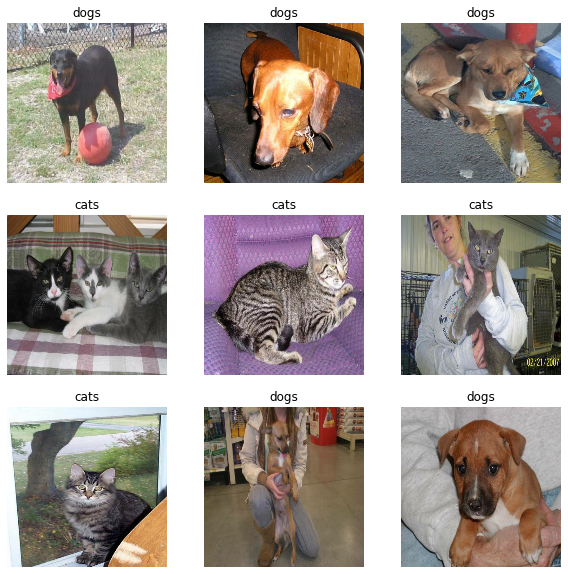

In [274]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Create a Dockefile

In [226]:
%%writefile Dockerfile

FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3

WORKDIR /

# Copies the trainer code to the docker image.
COPY trainer /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]

Writing Dockerfile


In [ ]:
if TRAIN_GPU:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_type": TRAIN_GPU,
        "accelerator_count": TRAIN_NGPU
    }
else:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_count": 0
    }
        
if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"
    
EPOCHS = 20
STEPS = 100

WORKER_POOL_SPEC = [
    {
        "replica_count": 1,
        "machine_spec": machine_spec,
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": ["gs://" + BUCKET_NAME + "/trainer_cifar.tar.gz"],
            "python_module": "trainer.task",
            "args": [
                "--model-dir=" + MODEL_DIR,
                "--epochs=" + str(EPOCHS),
                "--steps=" + str(STEPS),
                "--distribute=" + TRAIN_STRATEGY
            ],
        }
    }
]

### Assemble the job specification

Let's now assemble the description for the custom job specification.

In [ ]:
CUSTOM_JOB = {
    "display_name": JOB_NAME,
    "job_spec": {
        "worker_pool_specs": WORKER_POOL_SPEC
    }
}

### Examine the training package

#### Package layout

Before you start the training, let's look at how a Python package is assembled for a custom training job. When unarchived, the package contains the following directory/file layout.

- PKG-INFO
- README.md
- setup.cfg
- setup.py
- trainer
  - \_\_init\_\_.py
  - task.py

The files `setup.cfg` and `setup.py` are the instructions for installing the package into the operating environment of the docker image.

The file `trainer/task.py` is the python script for executing the custom job. *Note*, when we referred to it in the worker pool specification, we replace the directory slash with a dot (`trainer.task`) and dropped the file suffix (`.py`).

#### Package Assembly

In the following cells, you will assemble the training package.

In [ ]:
# Make folder for python training script
! rm -rf custom
! mkdir custom

# Add package information
! touch custom/README.md

setup_cfg = "[egg_info]\n\
tag_build =\n\
tag_date = 0"
! echo "$setup_cfg" > custom/setup.cfg

setup_py = "import setuptools\n\
# Requires TensorFlow Datasets\n\
setuptools.setup(\n\
    install_requires=[\n\
        'tensorflow_datasets==1.3.0',\n\
    ],\n\
    packages=setuptools.find_packages())" 
! echo "$setup_py" > custom/setup.py

pkg_info = "Metadata-Version: 1.0\n\
Name: UNKNOWN\n\
Version: 0.0.0\n\
Summary: Demostration training script\n\
Home-page: www.google.com\n\
Author: Google\n\
Author-email: UNKNOWN\n\
License: Public\n\
Description: Demo\n\
Platform: AI Platform (Unified)"
! echo "$pkg_info" > custom/PKG-INFO

# Make the training subfolder
! mkdir custom/trainer
! touch custom/trainer/__init__.py

#### Task.py Contents

In the next cell, you will write the contents of the training script task.py. I won't go into detail, it's just there for you to browse. In summary:

- Loads CIFAR10 dataset from TF Datasets (tfds).
- Builds a simple ConvNet model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and steps according to the arguments `args.epochs` and `args.steps`
- Saves the trained model (`save(args.model_dir)`) to the specified model directory.

In [ ]:
%%writefile custom/trainer/task.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--model-dir', dest='model_dir',
                    default='/tmp/saved_model', type=str, help='Model dir.')
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
  # Scaling CIFAR10 data from (0, 255] to (0., 1.]
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  datasets, info = tfds.load(name='cifar10',
                            with_info=True,
                            as_supervised=True)
  return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
model.save(args.model_dir)

#### Store training script on your Cloud Storage bucket

Next, we package the training folder into a compressed tar ball, and then store it in your Cloud Storage bucket.

In [ ]:
! rm -f custom.tar custom.tar.gz
! tar cvf custom.tar custom
! gzip custom.tar
! gsutil cp custom.tar.gz gs://$BUCKET_NAME/trainer_cifar.tar.gz

#### Create the training pipeline

Let's now create a training pipeline for your CIFAR10 custom training job.

In [ ]:
MODEL_NAME = 'cifar10_pipeline-' + TIMESTAMP
PIPELINE_DISPLAY_NAME = 'cifar10-training-pipeline-' + TIMESTAMP

training_task_inputs = json_format.ParseDict({"workerPoolSpecs": WORKER_POOL_SPEC},
                                             Value())
pipeline = {
    "display_name": PIPELINE_DISPLAY_NAME,
    "training_task_definition": CUSTOM_TASK_GCS_PATH,
    "training_task_inputs": training_task_inputs,
    "model_to_upload": {
        "display_name": PIPELINE_DISPLAY_NAME + '-model',
        "artifact_uri": MODEL_DIR,
        "container_spec": {
            "image_uri": DEPLOY_IMAGE,
            "command": ["/bin/tensorflow_model_server"],
            "args": [
                "--model_name=" + MODEL_NAME,
                "--model_base_path=" + MODEL_DIR,
                "--rest_api_port=8080",
                "--port=8500",
                "--file_system_poll_wait_seconds=31540000"
            ],
        }
    },
}

In [ ]:
PIPELINE_NAME = create_pipeline(pipeline)

### Get information on the training pipeline

Let's get the status on our custom training pipeline for CIFAR10 using the helper function we defined earlier `get_training_pipelime`. The job most likely will still be either PENDING or RUNNING.


In [ ]:
pipeline_response = get_training_pipeline(PIPELINE_NAME)

# Deployment

## Pre-Cooked

Training the above model may take upwards of ~5 minutes time. For expendiency, we have a pre-cooked (already trained) version of this model you can use for the next steps, while you wait for your model to finish training. 

Once your model is done training, you can repeat these steps for your trained model. You can calcuate the actual time it took to train the model by subtracting `end_time` from `start_time`. For your model, we will need to know the location of the saved model, which the Python script saved in your local Cloud Storage bucket at `MODEL_DIR + '/saved_model.pb'`.


You can choose between the precooked model or your trained model with the python variable `precooked` in the cell below.

In [ ]:
# Precooked flag
precook = False

if precook:
    model_path_to_deploy = "[not-implemented-yet]"
else:
    pipeline_response = get_training_pipeline(PIPELINE_NAME, True)
    if pipeline_response.state != aip.PipelineState.PIPELINE_STATE_SUCCEEDED:
        print("Training job has not completed")
        model_path_to_deploy = None
    else:
        model_path_to_deploy = MODEL_DIR

print("model_to_deploy:", model_path_to_deploy)

## Upload the model for serving

Your model is stored in a TF SavedModel format in a Cloud Storage bucket. Let's go ahead and load it from the Cloud Storage bucket, and then you can do some things, like evaluate the model, and do a prediction.

To load, we will use the TF.Keras `model.load_model()` method passing it the Cloud Storage path where the model is saved -- specified by `MODEL_DIR`.

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(MODEL_DIR)

## Evaluate the model

Now let's find out how good the model is. 

### Load evaluation data

We will load the CIFAR10 test (holdout) data from `tf.keras.datasets`, using the method `load_data()`. This will return the dataset as a tuple of two elements. The first element is the training data and the second is the test data. Each element is also a tuple of two elements: the image data, and the corresponding labels.

You don't need the training data, and hence why we loaded it as `(_, _)`.

Before you can run the data through evaluation, you need to preprocess it:

x_test:
1. Normalize (rescaling) the pixel data by dividing each pixel by 255. This will replace each single byte integer pixel with a 32-bit floating point number between 0 and 1.

y_test:<br/>
2. The labels are currently scalar (sparse). If you look back at the `compile()` step in the `trainer/task.py` script, you will find that it was compiled for sparse labels. So we don't need to do anything more.

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(_, _), (x_test, y_test) = cifar10.load_data()
x_test = (x_test / 255.0).astype(np.float32)

print(x_test.shape, y_test.shape)

### Evaluate the model

Let's evaluate how well the ConvNet model in the custom job did. Wahaha -- ~30%, not so good. Well, what does one expect with just 10 epochs and 200 steps per epoch -- see the `task.py fit() call`.

In [ ]:
model.evaluate(x_test, y_test)

## Upload the model for serving

Next, you will upload your TF.Keras model from the custom job to AI Platform (Unified) model service, which will create a AI Platform (Unified) model resource for your custom model. During upload, you need to define a serving function to convert data to the format your model expects. If you send encoded data to AI Platform, your serving function ensures that the data is decoded on the model server before it is passed as input to your model.

### Serving function for image data

To pass images to the prediction service, you encode the bytes into base 64 -- which makes the content safe from modification while transmitting binary data over the network. Since this deployed model expects input data as raw bytes, you need to ensure that the base 64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is part of the model's graph (instead of upstream on a CPU).

When you send a prediction or explanation request, the content of the request is base 64 decoded into a Tensorflow string, which is passed to the serving function (`serving_fn`). The serving function preprocesses the tf.string into raw numpy bytes (`preprocess_fn`) to match the input requirements of the model:
- `io.decode_jpeg`- Decompresses the JPG image which is returned as a Tensorflow vector with three channels (RGB).
- `image.convert_image_dtype` - Changes integer pixel values to float 32 and normalizes the values between the range 0 and 1.
- `image.resize` - Resizes the image to match the input shape for the model.
- `resized / 255.0` - Rescales (normalization) the pixel data between 0 and 1.

At this point, the data can be passed to the model (`m_call`).

In [ ]:
CONCRETE_INPUT = "numpy_inputs"

def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(32, 32))
    rescale = tf.cast(resized / 255.0, tf.float32)
    return rescale


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32, back_prop=False)
    return {CONCRETE_INPUT: decoded_images}  # User needs to make sure the key matches model's input


m_call = tf.function(model.call).get_concrete_function([tf.TensorSpec(shape=[None, 32, 32, 3], dtype=tf.float32, name=CONCRETE_INPUT)])


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


tf.saved_model.save(model, model_path_to_deploy, signatures={
    'serving_default': serving_fn,
})

## Get the serving function signature

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

For your purpose, you need the signature of the serving function. Why? Well, when we send our data for prediction as a HTTP request packet, the image data is base 64 encoded, and our TF.Keras model takes numpy input. Your serving function will do the conversion from base 64 to a numpy array. 

When making a prediction request, you need to route the request to the serving function instead of the model, so you need to know the input layer name of the serving function -- which you will use later when you make a prediction request.

In [ ]:
loaded = tf.saved_model.load(model_path_to_deploy)

input_name = list(loaded.signatures['serving_default'].structured_input_signature[1].keys())[0]
print('Serving function input:', input_name)

### Upload the Model

Use this helper function `upload_model` to upload your model, stored in SavedModel format, upto the model service, which will instantiate a AI Platform (Unified) model instance for our model. Once you've done that, you can use the model in the same way as any other AI Platform (Unified) model instance, such as deploying to an endpoint for serving predictions.

The helper function takes the parameters:

- `display_name`: A human readable name for the endpoint.
- `image_uri`: The container image for the model deployment.
- `model_uri`: The Cloud Storage path to our SavedModel artificat. For this tutorial, this is the Cloud Storage location where the `trainer/task.py` saved the model, which we specified in the variable `MODEL_DIR`.

The helper function uses the model client service and calls the method `upload_model`, which takes the parameters:

- `parent`: The AI Platform (Unified) location root path for dataset, model and endpoint resources. 
- `model`: The specification for the AI Platform (Unified) model instance.

Let's now dive deeper into the AI Platform (Unified) model specification `model`. This is a dictionary object that consists of the following fields:

- `display_name`: A human readable name for the model.
- `metadata_schema_uri`: Since our model was built without a AI Platform (Unified) managed dataset, we will leave this blank (`''`).
- `artificat_uri`: The Cloud Storage path where the model is stored in SavedModel format. 
- `container_spec`: This is the specification for the docker container that will be installed on the endpoint, from which the model will serve predictions.

Uploading a model into a AI Platform (Unified) model resource returns a long running operation, since it may take a few moments. You call `response.result()`, which is a synchronous call and will return when the AI Platform (Unified) model resource is ready. 

The helper function returns the AI Platform (Unified) fully qualified identifier for the corresponding AI Platform (Unified) model instance `upload_model_response.model`. You will save the identifier for subsequent steps in the variable `model_to_upload_name`.


In [ ]:
IMAGE_URI = DEPLOY_IMAGE


def upload_model(display_name, image_uri, model_uri):
    model = {
        "display_name": display_name,
        "metadata_schema_uri": "",
        "artifact_uri": model_uri,
        "container_spec": {
            "image_uri": image_uri
        },
    }
    response = clients['model'].upload_model(parent=PARENT, model=model)
    print("Long running operation:", response.operation.name)
    upload_model_response = response.result(timeout=180)
    print("upload_model_response")
    print(" model:", upload_model_response.model)
    return upload_model_response.model


model_to_deploy_name = upload_model("cifar10-" + TIMESTAMP, IMAGE_URI, model_path_to_deploy)

### List all models

Now that your custom model is uploaded as a AI Platform (Unified) managed model, let's get a list of all your AI Platform (Unified) managed models. Use this helper function `list_models`. This helper function uses the AI Platform (Unified) model client service, and calls the method `list_models`, with the parameter:

- `parent`: The AI Platform (Unified) location root path for your dataset, model and endpoint resources.

The response object from the call is a list, where each element is a AI Platform (Unified) managed model. For each model, you will display a few fields:

- `name`: The AI Platform (Unified) unique identifier for the managed model.
- `display_name`: The human readable name assigned to the model.
- `create_time`': Timestamp when the model resource was created.
- `update_time`: Timestamp when the model resource was last updated.
- `container`: The container image used for training the model.
- `artifact_uri`': The Cloud Storage location of the model artifact.

In [ ]:
def list_models():
    response = clients['model'].list_models(parent=PARENT)
    for model in response:
        print("name", model.name)
        print("display_name", model.display_name)
        print("create_time", model.create_time)
        print("update_time", model.update_time)
        print("container", model.container_spec.image_uri)
        print("artifact_uri", model.artifact_uri)
        print('\n')


list_models()

### Get model information

Now let's get the model information for just your model. Use this helper function `get_model`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed model.

This helper function uses the AI Platform (Unified) model client service, and calls the method `get_model`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed model.

In [ ]:
def get_model(name):
    response = clients['model'].get_model(name=name)
    print(response)


get_model(model_to_deploy_name)

### Create an endpoint

Use this helper function `create_endpoint` to create an endpoint to deploy the model to for serving predictions, with the parameter:

- `display_name`: A human readable name for the endpoint.

The helper function uses the endpoint client service and calls the method `create_endpoint`, which takes the parameter:

- `display_name`: A human readable name for the endpoint.

Creating an endpoint returns a long running operation, since it may take a few moments to provision the endpoint for serving. You call `response.result()`, which is a synchronous call and will return when the endpoint is ready. The helper function will return the AI Platform (Unified) fully qualified identifier for the endpoint -- `response.name`.


In [ ]:
ENDPOINT_NAME = "cifar10_endpoint-" + TIMESTAMP


def create_endpoint(display_name):
    endpoint = {"display_name": display_name}
    response = clients['endpoint'].create_endpoint(parent=PARENT, endpoint=endpoint)
    print("Long running operation:", response.operation.name)

    result = response.result(timeout=300)
    print("result")
    print(" name:", result.name)
    print(" display_name:", result.display_name)
    print(" description:", result.description)
    print(" labels:", result.labels)
    print(" create_time:", result.create_time)
    print(" update_time:", result.update_time)
    return result.name


endpoint_name = create_endpoint(ENDPOINT_NAME)

### Deploy model to the endpoint

Use this helper function `deploy_model` to deploy the model to the endpoint you created for serving predictions, with the parameters:

- `model`: The AI Platform (Unified) fully qualified model identifier of the model to upload (deploy) from the training pipeline.
- `deploy_mopdel_display_name`: A human readable name for the deployed model.
- `endpoint`: The AI Platform (Unified) fully qualified endpoint identifier to deploy the model to.

The helper function uses the endpoint client service and calls the method `deploy_model`, which takes the parameters:

- `endpoint`: The AI Platform (Unified) fully qualified endpoint identifier to deploy the model to.
- `deployed_model`: The requirements for deploying the model.
- `traffic_split`: Percent of traffic at endpoint that goes to this model, which is specified as a dictioney of one or more key/value pairs.
   - If only one model, then specify as { "0": 100 }, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then specify as, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
   
           { "0": percent, model_id: percent, ... }

Let's now dive deeper into the `deployed_model` parameter. This parameter is specified as a Python dictionary with the minimum required fields:

- `model`: The AI Platform (Unified) fully qualified model identifier of the (upload) model to deploy.
- `display_name`: A human readable name for the deployed model.
- `dedicated_resources`: This refers to how many redundant compute instances (replicas) and type of compute instance (machine_spec). For this example, we set it to one (no replication). If using a GPU, the corresponding container image must support a GPU.

Let's now dive deeper into the `traffic_split` parameter. This parameter is specified as a python dictionary. This might at first be a tad bit confusing. Let me explain, you can deploy more than one instance of your model to an endpoint, and then set how much (percent) goes to each instance. 

Why would you do that? Perhaps you already have a previous version deployed in production -- let's call that v1. You got better model evaluation on v2, but you don't know for certain that it is really better until you deploy to production. So in the case of traffic split, you might want to deploy v2 to the same endpoint as v1, but it only get's say 10% of the traffic. That way, you can monitor how well it does without disrupting the majority of users -- until you make a final decision.

In [ ]:
DEPLOYED_NAME = "cifar10_deployed-" + TIMESTAMP


def deploy_model(model, deployed_model_display_name, endpoint, traffic_split={"0": 100}):
    # Accelerators can be used only if the model specifies a GPU image.
    if DEPLOY_GPU:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_type": DEPLOY_GPU,
            "accelerator_count": DEPLOY_NGPU,
        }
    else:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_count": 0,
        }

    deployed_model = {
        "model": model,
        "display_name": deployed_model_display_name,
        # `dedicated_resources` must be used for non-AutoML models
        "dedicated_resources": {
            "min_replica_count": 1,
            "machine_spec": machine_spec
        },
    }

    response = clients['endpoint'].deploy_model(
        endpoint=endpoint, deployed_model=deployed_model, traffic_split=traffic_split)

    print("Long running operation:", response.operation.name)
    result = response.result()
    print("result")
    deployed_model = result.deployed_model
    print(" deployed_model")
    print("  id:", deployed_model.id)
    print("  model:", deployed_model.model)
    print("  display_name:", deployed_model.display_name)
    print("  create_time:", deployed_model.create_time)

    return deployed_model.id


deployed_model_id = deploy_model(model_to_deploy_name, DEPLOYED_NAME, endpoint_name)

### List all endpoints

Let's now get a list of all your endpoints. Use this helper function `list_endpoints`. 

The helper function uses the endpoint client service and calls the method `list_endpoints`. The returned response object is a list, with an element for each endpoint. The helper function lists a few example fields for each endpoint:

- `name`: The AI Platform (Unified) identifier for the managed endpoint.
- `display_name`: The human readable name you assigned to the endpoint.
- `create_time`: When the endpoint was created.
- `deployed_models`: The models and associated information that are deployed to this endpoint.

In [ ]:
def list_endpoints():
    response = clients['endpoint'].list_endpoints(parent=PARENT)
    for endpoint in response:
        print("name:", endpoint.name)
        print("display name:", endpoint.display_name)
        print("create_time:", endpoint.create_time)
        print("deployed_models", endpoint.deployed_models)
        print("\n")
        
list_endpoints()

### Get information on this endpoint

Now let's get the endpoint information for just your endpoint. Use this helper function `get_endpoint`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed endpoint.

This helper function uses the AI Platform (Unified) endpoint client service, and calls the method `get_endpoint`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed endpoint.

In [ ]:
def get_endpoint(name):
    response = clients['endpoint'].get_endpoint(name=name)
    print(response)
    
get_endpoint(endpoint_name)

## Make a prediction request

Let's now do a prediction to your deployed model. You will use an arbitrary image out of the test (holdout) portion of the dataset as a test image. 

In [ ]:
test_image = x_test[0]
test_label = y_test[0]
print(test_image.shape)

### Prepare the request content
You are going to send the CIFAR10 image as compressed JPG image, instead of the raw uncompressed bytes:

- `cv2.imwrite`: Use openCV to write the uncompressed image to disk as a compressed JPEG image.
- `tf.io.read_file`: Read the compressed JPG images back into memory as raw bytes.
- `base64.b64encode`: Encode the raw bytes into a base 64 encoded string.

In [ ]:
import base64
import cv2
cv2.imwrite('tmp.jpg', (test_image * 255).astype(np.uint8))

bytes = tf.io.read_file('tmp.jpg')
b64str = base64.b64encode(bytes.numpy()).decode('utf-8')

### Send the prediction request

Ok, now you have a test image. Use this helper function `predict_image`, which takes the parameters:

- `image`: The test image data as a numpy array.
- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model was deployed.
- `parameters_dict`: Additional parameters for serving -- in our case we will pass None.

This function uses the prediction client service and calls the `predict` method with the parameters:

- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model was deployed.
- `instances`: A list of instances (encoded images) to predict.
- `parameters`: Additional parameters for serving -- in our case we will pass None.

To pass the image data to the prediction service, in the previous step you encoded the bytes into base 64 -- which makes the content safe from modification when transmitting binary data over the network. You need to tell the serving binary where your model is deployed to, that the content has been base 64 encoded, so it will decode it on the other end in the serving binary. 

Each instance in the prediction request is a dictionary entry of the form:

                        {input_name: {'b64': content }}
                        
- `input_name`: the name of the input layer of the underlying model.
- `'b64'`: A key that indicates the content is base 64 encoded.
- `content`: The compressed JPG image bytes as a base 64 encoded string.

Since the `predict()` service can take multiple images (instances), you will send your single image as a list of one image. As a final step, you package the instances list into Google's protobuf format -- which is what we pass to the `predict()` service.

The `response` object returns a list, where each element in the list corresponds to the corresponding image in the request. You will see in the output for each prediction:

- Confidence level for the prediction (`predictions`, between 0 and 1, for each of the ten classes.

In [ ]:
def predict_image(image, endpoint, parameters_dict):
    # The format of each instance should conform to the deployed model's prediction input schema.
    instances_list = [{input_name: {'b64': image}}]
    instances = [json_format.ParseDict(s, Value()) for s in instances_list]

    response = clients['prediction'].predict(endpoint=endpoint, instances=instances, parameters=parameters_dict)
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    predictions = response.predictions
    print("predictions")
    for prediction in predictions:
        # See gs://google-cloud-aiplatform/schema/predict/prediction/classification.yaml for the format of the predictions.
        print(" prediction:", prediction)


predict_image(b64str, endpoint_name, None)

## Undeploy the model

Let's now undeploy your model from the serving endpoint. Use this helper function `undeploy_model`, which takes the parameters:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the model was deployed.
- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model is deployed.

This function uses the endpoint client service and calls the method `undeploy_model`, with the parameters:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the model was deployed.
- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model is deployed.
- `traffic_split`: How to split traffic among the remaining deployed models on the endpoint.

Since this is the only deployed model on the endpoint, we simply can leave `traffic_split` empty by setting it to {}.

In [ ]:
def undeploy_model(deployed_model_id, endpoint):
    response = clients['endpoint'].undeploy_model(endpoint=endpoint, deployed_model_id=deployed_model_id, traffic_split={})
    print(response)


undeploy_model(deployed_model_id, endpoint_name)

# Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Dataset
- Model
- Endpoint
- Cloud Storage Bucket

In [ ]:
delete_dataset = True
delete_model = True
delete_endpoint = True
delete_bucket = True

# Delete the dataset using the AI Platform (Unified) fully qualified identifier for the dataset
try:
    if delete_dataset:
        clients['dataset'].delete_dataset(name=dataset['name'])
except Exception as e:
    print(e)

# Delete the model using the AI Platform (Unified) fully qualified identifier for the model
try:
    if delete_model:
        clients['model'].delete_model(name=model_to_deploy_name)
except Exception as e:
    print(e)

# Delete the endpoint using the AI Platform (Unified) fully qualified identifier for the endpoint
try:
    if delete_endpoint:
        clients['endpoint'].delete_endpoint(name=endpoint_name)
except Exception as e:
    print(e)

if delete_bucket and 'BUCKET_NAME' in globals():
    ! gsutil rm -r gs://$BUCKET_NAME